# Notebook exploring and generating topic models on South Austrlalian exploration envelope summaries

## Import required libraries

In [14]:
import pandas as pd
import numpy as np

from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from collections import Counter,OrderedDict, defaultdict

from nltk.probability import FreqDist

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('max_columns', 30)
pd.set_option('display.max_colwidth', 200)

## Load the pre-processed and cleaned abstracts and metadata, then create a subset dataframe containing only the required columns for further processing

In [15]:
Abstract_df = pd.read_csv(r'D:\Python ML\Envelope-key-words\Data\Interim\processed_env_abstracts_20201125.csv')

In [16]:
Abstract_df.head(2)

,Unnamed: 0,ID,envelopeOCR,Reference,Category,Title,Publication Date,Author,Prepared by,Source,Collation,Format,Client,Broad Subject,Subject Terms,Abstract,Notes,Tenement,Licensee,Mine Name,Map Sheet,Locality,Geol. Province,Drillhole,Assays,Stratigraphy,Date Added,Download Document Size,normalised_ENV,normalised_Abstract
0,0,ENV00002,"2CONTENTS ENVELOPE 2Geosurveys of Australta Ltd.Santos Ltd.,REPORT Interim Report of the Geological Investigations carriedout on the Central Flinders Ranges.Geological Map Western Margin of Centra...",ENV00002,Company petroleum exploration licence reports,Interim report of the geological investigations carried out on the central Flinders Ranges.,30-Jun-56,"Scott, D.C.;Wopfner, H.;Grasso, R.",Geosurveys of Australia Ltd,"South Australia. Department of Mines. Open file Envelope, 00002","Total fiche: 2, Total pages: 4, 1 plans, 1 reps",Digital Hard Copy,NaN,Petroleum exploration;Structural geology,Photointerpretation;Geological mapping,"Survey aimed to obtain broad structural picture. It showed development of synclinal and anticlinal structures, the pitch reversals of which have produced domes and basins which could be of oil res...",NaN,NaN,Santos Ltd,NaN,PORT AUGUSTA;6433I;ORROROO;6533;PARACHILNA;6534;TORRENS;6434II,Flinders Ranges,Arrowie Basin;Adelaide Geosyncline,NaN,NaN,NaN,20/08/1986,186.0,contents envelope geosurveys australta ltd santos ltd report interim report geological investigation carriedout central flinder ranges geological map western margin centra flinderstenement tenemen...,survey aim obtain broad structural picture show development synclinal anticlinal structure pitch reversal produce dome basin could oil reservoir type reproduce cambrian sediment pirie torren basin
1,7,ENV00007,CONTENTS ENVELOPE 7TENEMENT O.E.L. 24 - St. Vincents Gulf Graben & Adjacent.TENEMENT HOLDER': Geosurveys Of Australia Ltd.REPORT Oil & Gas Possibilities.Pgs. 3-6503CFCIVF81 81FEE FEEFEEI96E 196LEE...,ENV00007,Company petroleum exploration licence reports,Preliminary review of oil and gas possibilities of Saint Vincent Gulf graben and adjacent.,1961,"Sprigg, R.C.",NaN,"South Australia. Department of Mines. Open file Envelope, 00007","Total fiche: 2, Total pages: 65, 0 plans, references, 1 reps",Hard Copy Digital,NaN,Petroleum exploration;Geophysics,Exploration potential;Literature reviews;Stratigraphy;Structural geology,"Includes geological logs of the following bores: Croydon Bore (Hd Yatala), Pethicks Bore: Oaklands (Hd Adelaide, secn 147), Hd Dublin, secn 97, Hd Grace, secn 17 Inkerman Balaklava Coal Bore (Hd I...",Earlier draft of report in Env 8. Differs by containing appendix of logs or previously drilled bores.,OEL00024,Geosurveys of Australia Pty Ltd,NaN,ADELAIDE;6528;6529;MAITLAND;6428;6429;BARKER;6527;KINGSCOTE;6427;6426,Gulf Saint Vincent,Stansbury Basin;St Vincent Basin,Croydon Bore;Pethicks Bore;Inkerman Balaklava Coal Bore;Minlaton Stratigraphic 1;Minlaton Township 1;Peninsula Oil Bore;Kingscote Bore,NaN,NaN,31/12/1983,1973.0,content envelope tenement st vincents gulf graben adjacent tenement holder geosurvey australia ltd report oil gas possibilities pg cfcivf fee feefeeie leet cf etwssryfor office use onlyooundesseil...,include geological log follow bore croydon bore hd yatala pethick bore oakland hd adelaide secn hd dublin secn hd grace secn inkerman balaklava coal bore hd inkerman secn bear ia govt minlaton str...


Example of one of the provided abstracts for on of the early exploration envelopes

In [17]:
print(Abstract_df.Abstract[0])

Survey aimed to obtain broad structural picture. It showed development of synclinal and anticlinal structures, the pitch reversals of which have produced domes and basins which could be of oil reservoir type if reproduced in the Cambrian sediments under the Pirie-Torrens Basin.


In [18]:
df = Abstract_df[['ID','Category','Title','Publication Date', 'Format', 'Broad Subject','Notes', 'Tenement', 'normalised_Abstract']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5894 entries, 0 to 5893
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   5894 non-null   object
 1   Category             5894 non-null   object
 2   Title                5894 non-null   object
 3   Publication Date     5630 non-null   object
 4   Format               5886 non-null   object
 5   Broad Subject        5892 non-null   object
 6   Notes                2753 non-null   object
 7   Tenement             5465 non-null   object
 8   normalised_Abstract  5894 non-null   object
dtypes: object(9)
memory usage: 414.5+ KB


## Do some simple EDA. 
 
Check how many categories the data already has and what they are. Tokenise the normalised abstracts for further analysis including length of abstract (number of words) and have a look at the most common words

In [19]:
print(df['Category'].unique())

['Company petroleum exploration licence reports' 'DSD publications'
 'Non-DSD publications, theses and miscellaneous reports'
 'Company mineral exploration licence reports' 'Departmental publications'
 'External publications, theses and miscellaneous reports'
 'Company mining program' 'Mineral Production Licence report'
 'Geothermal exploration licence reports']


In [20]:
df['Abstract_toks'] = df['normalised_Abstract'].apply(simple_preprocess)

In [21]:
df['Abstract_len'] = df['Abstract_toks'].apply(len)

In [22]:
df.sample(5)

,ID,Category,Title,Publication Date,Format,Broad Subject,Notes,Tenement,normalised_Abstract,Abstract_toks,Abstract_len
4137,ENV09889,DSD publications,"Officer Basin SEEBASE Project, SRK Project Code: PI11.",NaN,Digital,Geology;Hydrocarbon: Stratigraphy,NaN,NaN,project initiate pirsa augment marketing campaign attract new hydrocarbon explorer stansbury provide new insight geology hence reduce exploration risk srk contract march provide integrated regiona...,"[project, initiate, pirsa, augment, marketing, campaign, attract, new, hydrocarbon, explorer, stansbury, provide, new, insight, geology, hence, reduce, exploration, risk, srk, contract, march, pro...",41
162,ENV00407,Company mineral exploration licence reports,"Moonta-Wallaroo area. Progress reports to licence expiry/renewal, for the period 1/9/1963 to 31/8/1965.",24-Sep-64,Digital Hard Copy Hard Copy,Mineral exploration - SA;Drilling;Geophysics;Geochemistry,"Continuation of tenure over same area formerly held as SML 42. Please refer to Env 6999 to see SML 59 six-monthly reports for the periods ending 28/2/65 and 31/8/65 (fiche: 1, pgs 19-31). Licence ...",SML00059,report discuss ongoing geophysical geochemical diamond drilling investigation regional magnetic feature around northern end yorke peninsula targette hide supergene copper gold mineralisation moont...,"[report, discuss, ongoing, geophysical, geochemical, diamond, drilling, investigation, regional, magnetic, feature, around, northern, end, yorke, peninsula, targette, hide, supergene, copper, gold...",61
2800,ENV06936,Company petroleum exploration licence reports,"1988 Forrest-LEY Seismic Survey, Lake Eyre Block. Geophysical interpretation report (Tirari and Lake Peera areas).",Jan-90,Hard Copy Digital,Petroleum exploration;Geophysics;Drilling,"Includes sets of time structure maps for the principal mapped seismic horizons in each target area, plus figures depicting regional and Block structural elements and a representative reduced seism...",PEL00005;PEL00006,total line use interpretation lake eyre block make line line line line survey poonarunna lake view miandana pedirka south block provide well control six horizon dn da pick map area survey programm...,"[total, line, use, interpretation, lake, eyre, block, make, line, line, line, line, survey, poonarunna, lake, view, miandana, pedirka, south, block, provide, well, control, six, horizon, dn, da, p...",110
3434,ENV08958,Company mineral exploration licence reports,Billeroo West and Lake Charles. Data release made in lieu of submitting separate first partial surrender reports for ELs 2013 and 2560 : annual reports for the period 1/9/1994 to 25/10/2000.,Nov-00,Digital Hard Copy,Mineral exploration - SA;Geophysics;Drilling;Geochemistry;Petrology;Sedimentary geology;Palaeontology,"See related prior EL 1860 annual reports held separately in Env 8870. Includes: - Gravestock, D.I., 1999. Report on Cambrian limestone in drillhole LD97001 (PIRSA geological consultant's report fo...",EL01860;EL02013;EL02560,exploration area eastern flank benagerie ridge km north mingary target stratiform pb zn ag mineralisation associate metasediment bimba formation interpret lateral equivalent broken hill group foll...,"[exploration, area, eastern, flank, benagerie, ridge, km, north, mingary, target, stratiform, pb, zn, ag, mineralisation, associate, metasediment, bimba, formation, interpret, lateral, equivalent,...",119
2762,ENV06862,"Non-DSD publications, theses and miscellaneous reports",Southern Cross Refinery. Supplement to the draft Environmental Impact Statement.,Jun-87,Hard Copy Digital,Environmental protection,NaN,NaN,effect proposal petrochemical complex port bonython summarise regard major issue raise santos ltd mr scott corporation city whyalla environmental protection council government department major obj...,"[effect, proposal, petrochemical, complex, port, bonython, summarise, regard, major, issue, raise, santos, ltd, mr, scott, corporation, city, whyalla, environmental, prot

In [23]:
# Create a list of all individual words in all the abstracts
words = df.normalised_Abstract.str.split()
allwords = []
for wordlist in words:
    allwords+= wordlist

print(f'There are {len(allwords)} in total')

There are 841074 in total


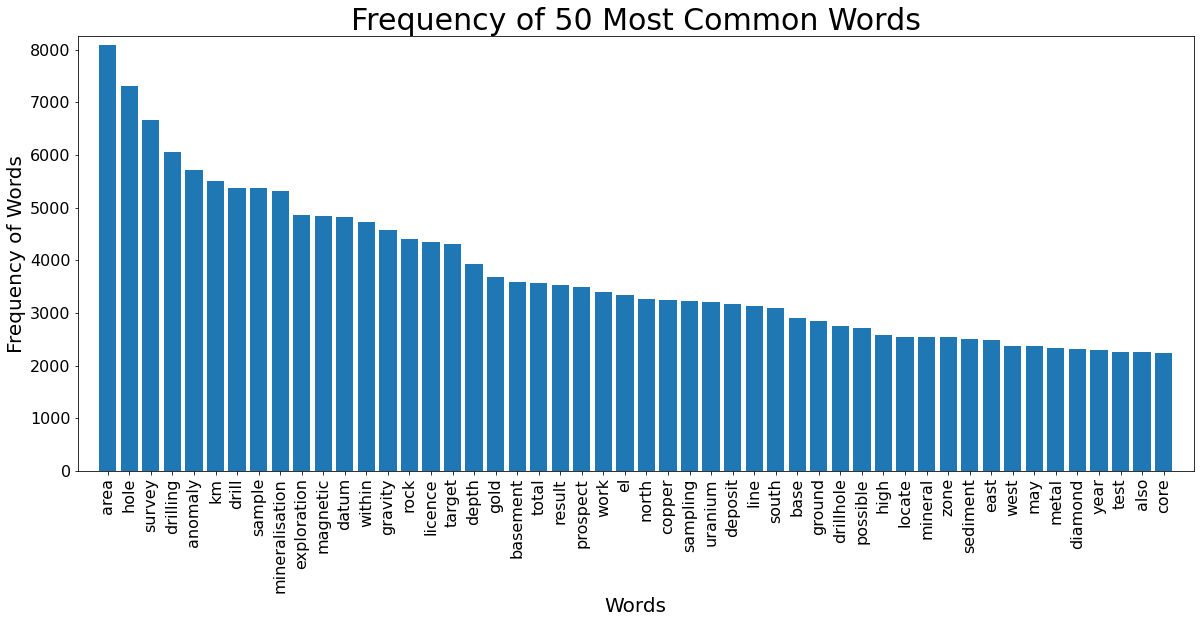

In [24]:
mostcommon_small = FreqDist(allwords).most_common(50)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(20,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.title('Frequency of 50 Most Common Words', fontsize=30)
plt.savefig(r"D:\Python ML\Envelope-key-words\Notebooks\Abstract LDA\Figures\Freq_most_common_words.png")
plt.show()

In [16]:
# possible words to drop because of high frequency and low relevance. This is not implemented in this notebook
words_to_drop = ['km', 'area', 'within', 'datum', 'licence', 'year', 'use', 'may', 'kms', 'metre', 'north', 'east', 'west', 'also', 'south']

# Create the input datasets including bi-grams and tri-grams, dictionary and corpus for LDA modelling

In [17]:
data_words = df.Abstract_toks.to_list()

In [18]:
# build bigram and trigram models

bigram = models.Phrases(data_words, min_count=5, threshold=30)
trigram = models.Phrases(bigram[data_words], threshold=100)
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)

In [19]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [20]:
data_words_trigrams = make_trigrams(data_words)

In [21]:
# example docs with built bi-grams and tri-grams
print(data_words_trigrams[0:5])

[['survey', 'aim', 'obtain', 'broad', 'structural', 'picture', 'show', 'development', 'synclinal', 'anticlinal_structure', 'pitch', 'reversal', 'produce', 'dome', 'basin', 'could', 'oil', 'reservoir', 'type', 'reproduce', 'cambrian', 'sediment', 'pirie_torren_basin'], ['include', 'geological', 'log', 'follow', 'bore', 'croydon', 'bore', 'hd', 'yatala', 'pethick', 'bore', 'oakland', 'hd', 'adelaide', 'secn', 'hd', 'dublin', 'secn', 'hd', 'grace', 'secn', 'inkerman', 'balaklava', 'coal', 'bore', 'hd', 'inkerman', 'secn', 'bear', 'ia', 'govt', 'minlaton', 'stratigraphic', 'bear', 'hd', 'ramsay', 'secn', 'minlaton', 'township', 'bore', 'hd', 'ramsay', 'secn', 'peninsula', 'oil', 'bore', 'peezie', 'swamp', 'hd', 'moorowie', 'secn', 'kingscote', 'bore', 'hd', 'menzie'], ['area', 'prolonged', 'active', 'deep', 'sedimentation', 'probably', 'dominantly', 'marine', 'dark', 'coloured', 'shale', 'marl', 'limestone', 'offer', 'promise', 'source', 'rock', 'condition', 'adequate', 'reservoir', 'sand'

In [26]:
# the final list of top 100 words ranked by frequency
finalList =[]
for sublist in data_words:
    for item in sublist:
        finalList.append(item)
c = Counter(finalList)
print(sorted(c.items(), key=lambda x:x[1],reverse=True)[:100])

[('area', 8095), ('hole', 7313), ('survey', 6674), ('drilling', 6057), ('anomaly', 5720), ('km', 5509), ('drill', 5383), ('sample', 5380), ('mineralisation', 5319), ('exploration', 4867), ('magnetic', 4840), ('datum', 4816), ('within', 4721), ('gravity', 4568), ('rock', 4405), ('licence', 4346), ('target', 4311), ('depth', 3935), ('gold', 3680), ('basement', 3585), ('total', 3562), ('result', 3534), ('prospect', 3486), ('work', 3401), ('el', 3349), ('north', 3267), ('copper', 3254), ('sampling', 3227), ('uranium', 3202), ('deposit', 3171), ('line', 3139), ('south', 3093), ('base', 2912), ('ground', 2854), ('drillhole', 2757), ('possible', 2708), ('high', 2578), ('locate', 2545), ('mineral', 2541), ('zone', 2540), ('sediment', 2498), ('east', 2485), ('west', 2377), ('may', 2368), ('metal', 2330), ('diamond', 2310), ('year', 2300), ('test', 2260), ('also', 2257), ('core', 2244), ('geochemical', 2243), ('two', 2242), ('low', 2221), ('regional', 2187), ('part', 2173), ('along', 2161), ('po

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words_trigrams]

# Train the LDA model.

To asses the number of topics we will train a number of models with 3 to 12 topics as well as train both umass and cv coherence scores for each. We can then plot and asses the coherence scores to determin the optimal number of topics

In [136]:
# topic classification using LDA. Having real issues with this on Windows trowing broken pipe error. Multiprocessing not working hence the __name__ block and using LdaModel.

if __name__=='__main__':
    Lda = models.LdaModel
    coherenceList_umass = []
    coherenceList_cv = []
    num_topics_list = np.arange(3,12)
    for num_topics in tqdm(num_topics_list):
        lda= Lda(corpus, num_topics=num_topics,id2word = id2word, 
                passes=20,chunksize=2000,random_state=43)
        cm = CoherenceModel(model=lda, corpus=corpus, 
                            dictionary=id2word, coherence='u_mass')
        coherenceList_umass.append(cm.get_coherence())
        cm_cv = CoherenceModel(model=lda, 
                            texts=data_words_trigrams, dictionary=id2word, coherence='c_v') #corpus=corpus,
        coherenceList_cv.append(cm_cv.get_coherence())
        vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
        pyLDAvis.save_html(vis,f'Figures\\pyLDAvis_{num_topics}.html')

100%|██████████| 9/9 [26:21<00:00, 175.72s/it]


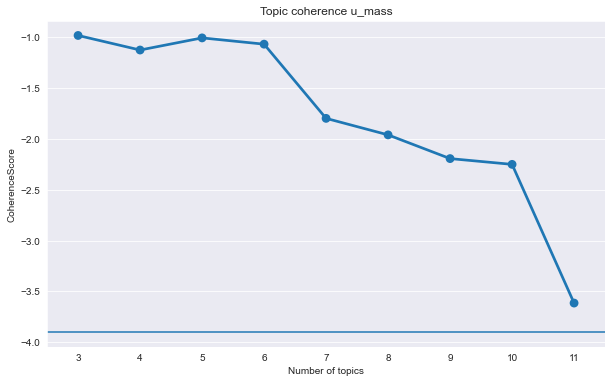

In [137]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence u_mass')
plt.savefig('Topic coherence plot u_mass_iter2.png')

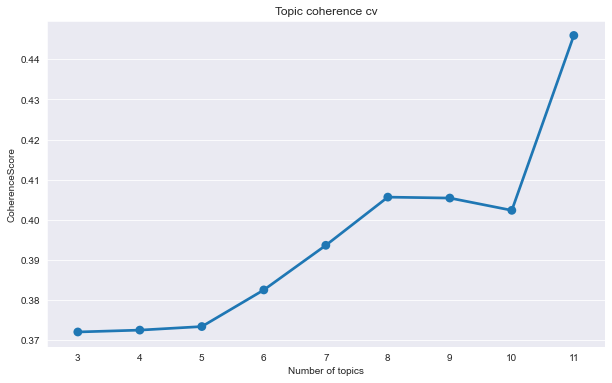

In [138]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_cv})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
#plt.axhline(y=-3.9)
plt.title('Topic coherence cv')
plt.savefig('Topic coherence plot c_v_iter2.png')

## Generate the final model with the optimised number of topics, and save the model, dictionary and corpus

In [31]:
Lda = models.LdaModel #used instead of parallelised LdaMulticore
lda_final= Lda(corpus, num_topics=8,id2word = id2word, passes=20,chunksize=2000,random_state=43)

In [143]:
lda_final.save('abstracts_lda_8_all_words_20201126')
id2word.save('abstracts_dictionary_20201126')
corpora.MmCorpus.serialize('corpus_doc_term_matrix_20201126.mm', corpus)

## Visualising the final topic model with pyLDAvis

In [34]:
#Visualizing with pyLDAviz
num_topics = 8
vis = pyLDAvis.gensim.prepare(lda_final, corpus, id2word,sort_topics=False)
#pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')
pyLDAvis.enable_notebook()
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.048401 -0.049179       1        1   9.700699
1      0.110317 -0.002556       2        1  31.822340
2      0.118021  0.061071       3        1  26.565557
3     -0.387092  0.005593       4        1   0.610204
4      0.046625 -0.147696       5        1  11.915023
5     -0.025732 -0.079218       6        1   6.855799
6      0.068991 -0.038574       7        1   7.949810
7      0.020469  0.250559       8        1   4.580569, topic_info=             Term         Freq        Total Category  logprob  loglift
20         survey  6508.000000  6508.000000  Default  30.0000  30.0000
647      magnetic  4432.000000  4432.000000  Default  29.0000  29.0000
269       anomaly  5500.000000  5500.000000  Default  28.0000  28.0000
56           area  7853.000000  7853.000000  Default  27.0000  27.0000
492       gravity  4277.000000  4277.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
463          plus   164.159557  1251.364611   Topic8  -5.3475   1.0522
176      drilling   197.312912  5884.450281   Topic8  -5.1635  -0.3119
2544  geochemical   168.359877  1600.642641   Topic8  -5.3222   0.8313
236          near   164.831403  1420.952315   Topic8  -5.3434   0.9292
1024         hole   174.844867  7228.529900   Topic8  -5.2844  -0.6385

[618 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3450      8  0.990785   acacia
2450      2  0.819162  acquire
2450      3  0.002147  acquire
2450      5  0.025767  acquire
2450      6  0.132054  acquire
...     ...       ...      ...
477       3  0.606329     zone
477       5  0.104620     zone
477       6  0.026969     zone
477       7  0.001395     zone
477       8  0.000465     zone

[1512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

## Extract the relevent words and token frequency for each topic

In [35]:
def get_relevant_words(vis,lam=0.3,topn=20):
    """Function to extract the relevent words from each modelled topic

    Parameters
    ---------
        vis : PreparedData created using `pyLDAvis.gensim.prepare()`
        lam : int; lambda value for term relevence `(term w | topic t) = λ * p(w | t) + (1 - λ) * p(w | t)/p(w); see Sievert & Shirley (2014)`
        topn : The number number of relevent terms to return
    
    Returns
    ---------
        relevent_words : pandas.DataFrame containing the Topic, topic_id, n Relevant_words as list and Frequency of tokens in each topic
    """ 
    
    a = vis.topic_info
    a['relevance'] = a['logprob']*lam+(1-lam)*a['loglift'] # this calculates the relevance value as in plLDAvis
    a = a.loc[:,['Category','Term','relevance']].groupby(['Category'])\
    .apply(lambda x: x.sort_values(by='relevance',ascending=False).head(topn))
    a = a.loc[:,'Term'].reset_index().loc[:,['Category','Term']]
    a = a[a['Category']!='Default']
    topics = a.Category.tolist()
    terms = a.Term.tolist()
    d = defaultdict(list)
    for top, term in zip(topics,terms):
        d[top].append(term)
    relevent_words = pd.DataFrame([d]).T.reset_index()
    relevent_words.columns = ['Topic','Relevant_words']

    token_percent = vis.topic_coordinates.sort_values(by='topics').loc[:,['topics','Freq']].reset_index().rename(columns={'topic':'topic_id'})
    return relevent_words.join(token_percent,how='left').drop('topics',axis=1)

In [36]:
final_topics = get_relevant_words(vis, 0.3)
final_topics

,Topic,Relevant_words,topic_id,Freq
0,Topic1,"[uranium, coal, sand, tertiary, clay, lignite, channel, palaeochannel, sedimentary_uranium, groundwater, eyre_formation, rotary, beverley, gamma_ray_log, talc, seam, radioactivity, sediment, radio...",0,9.700699
1,Topic2,"[gravity, basement, magnetic, iocg, anomaly, datum, el, target, depth, geophysical, km, survey, olympic_dam, acquire, station, station_read, interpret, drill, feature, minotaur]",1,31.822340
2,Topic3,"[gold, soil, sample, rock_chip, copper, value, sampling, au, base_metal, mineralisation, anomalous, geochemical, return, assay, vein, prospect, ppm, zone, bedrock, calcrete]",2,26.565557
3,Topic4,"[gel, geothermal, gel_grant, desktop, heat, surrender_th, thermal_conductivity, energy_ltd, vacuum, hot_dry, nd, commit, hot, heat_produce_granite, impasse, munyarai, ddcop, nicul, mount_james, sa...",3,0.610204
4,Topic5,"[resource, mining, iron_ore, ore, sub_block, recovery, grade, plant, hillside, technical, metallurgical, mine, iron, resource_estimate, year, beneficiation, cost, concentrate, orebody, havilah]",4,11.915023
5,Topic6,"[seismic, pel, petroleum, kms, survey, gas, hydrocarbon, reservoir, epp, oil, closure, moomba, comprise_detail_operation_field, cooper_basin, record, line, otway_basin, velocity, mature, acquisiti...",5,6.855799
6,Topic7,"[hm, relinquish, iluka, licence, heavy_mineral, gypsum, relinquish_portion, surrender, strandline, magnesite, portion, murray_basin, eucla_basin, iluka_resource, dune, ooldea, tenement, hms, beach...",6,7.949810
7,Topic8,"[kimberlite, foot, mineralization, indicator_mineral, kimberlitic, aerial, diamond, loam, kimberlite_indicator_mineral, grain, fdl, cattlegrid, microdiamond, kimberlitic_indicator_mineral, stockda...",7,4.580569


In [37]:
# create topic:relevant_words map and topic_id:human topic map

rel_words_map = dict(zip(final_topics.topic_id, final_topics.Relevant_words))

topic_map = {0: 'Uranium and coal exploration', 1: 'IOCG exploration', 2: 'Gold, copper, base metal exploration', 3: 'Geothermal', 4: 'Mine operations and development',
                5: 'Oil and gas', 6: 'Heavy minerals, ?extractives and environmental', 7: 'Diamond exploration'}


## Find main topic for each document and tag with the key words

In [38]:
def main_topic_doc(ldamodel, corpus=corpus):
    """Function to extract the dominant topic, its percent contribution and 10 top keywords for each document in a corpus

    Parameters
    ---------
        ldamodel : `gensim.models.ldamodel.LdaModel` An already trained Gensim LdaModel.
        corpus : array-like list of bag of word docs in tuple form or scipy CSC matrix. The corpus in bag of word form, the same docs used to train the model.
    
    Returns
    ---------
        document_topics : pandas.DataFrame containing the Dominant_Topic, Percent_Contrib and Topic_keywords for each document in the corpus
    """ 
    
    doc_topics = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = "' ".join([word for word, prop in wp])
                doc_topics = doc_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics.columns = ['Dominant_Topic', 'Percent_Contrib', 'Topic_keywords']
    return doc_topics


In [39]:
main_topics = main_topic_doc(lda_final)
main_topics.head(5)

,Dominant_Topic,Percent_Contrib,Topic_keywords
0,5.0,0.6496,survey' seismic' datum' line' area' km' record' result' total' well
1,3.0,0.9843,gel' geothermal' area' th' salt' temperature' energy' gel_grant' desktop' brine
2,0.0,0.5066,uranium' hole' drilling' sand' sediment' drill' tertiary' deposit' within' sample
3,5.0,0.6216,survey' seismic' datum' line' area' km' record' result' total' well
4,5.0,0.4900,survey' seismic' datum' line' area' km' record' result' total' well


In [40]:
main_topics['Topic_Name'] = main_topics['Dominant_Topic'].map(topic_map)
main_topics['Relevent_words'] = main_topics["Dominant_Topic"].map(rel_words_map)
main_topics

,Dominant_Topic,Percent_Contrib,Topic_keywords,Topic_Name,Relevent_words
0,5.0,0.6496,survey' seismic' datum' line' area' km' record' result' total' well,Oil and gas,"[seismic, pel, petroleum, kms, survey, gas, hydrocarbon, reservoir, epp, oil, closure, moomba, comprise_detail_operation_field, cooper_basin, record, line, otway_basin, velocity, mature, acquisiti..."
1,3.0,0.9843,gel' geothermal' area' th' salt' temperature' energy' gel_grant' desktop' brine,Geothermal,"[gel, geothermal, gel_grant, desktop, heat, surrender_th, thermal_conductivity, energy_ltd, vacuum, hot_dry, nd, commit, hot, heat_produce_granite, impasse, munyarai, ddcop, nicul, mount_james, sa..."
2,0.0,0.5066,uranium' hole' drilling' sand' sediment' drill' tertiary' deposit' within' sample,Uranium and coal exploration,"[uranium, coal, sand, tertiary, clay, lignite, channel, palaeochannel, sedimentary_uranium, groundwater, eyre_formation, rotary, beverley, gamma_ray_log, talc, seam, radioactivity, sediment, radio..."
3,5.0,0.6216,survey' seismic' datum' line' area' km' record' result' total' well,Oil and gas,"[seismic, pel, petroleum, kms, survey, gas, hydrocarbon, reservoir, epp, oil, closure, moomba, comprise_detail_operation_field, cooper_basin, record, line, otway_basin, velocity, mature, acquisiti..."
4,5.0,0.4900,survey' seismic' datum' line' area' km' record' result' total' well,Oil and gas,"[seismic, pel, petroleum, kms, survey, gas, hydrocarbon, reservoir, epp, oil, closure, moomba, comprise_detail_operation_field, cooper_basin, record, line, otway_basin, velocity, mature, acquisiti..."
...,...,...,...,...,...
5889,2.0,0.6765,gold' sample' mineralisation' hole' copper' area' prospect' drilling' sampling' rock,"Gold, copper, base metal exploration","[gold, soil, sample, rock_chip, copper, value, sampling, au, base_metal, mineralisation, anomalous, geochemical, return, assay, vein, prospect, ppm, zone, bedrock, calcrete]"
5890,2.0,0.7865,gold' sample' mineralisation' hole' copper' area' prospect' drilling' sampling' rock,"Gold, copper, base metal exploration","[gold, soil, sample, rock_chip, copper, value, sampling, au, base_metal, mineralisation, anomalous, geochemical, return, assay, vein, prospect, ppm, zone, bedrock, calcrete]"
5891,2.0,0.7207,gold' sample' mineralisation' hole' copper' area' prospect' drilling' sampling' rock,"Gold, copper, base metal exploration","[gold, soil, sample, rock_chip, copper, value, sampling, au, base_metal, mineralisation, anomalous, geochemical, return, assay, vein, prospect, ppm, zone, bedrock, calcrete]"
5892,4.0,0.4997,drilling' resource' drill' project' prospect' hole' use' work' mine' ore,Mine operations and development,"[resource, mining, iron_ore, ore, sub_block, recovery, grade, plant, hillside, technical, metallurgical, mine, iron, resource_estimate, year, beneficiation, cost, concentrate, orebody, havilah]"


## Join the main topics, keywords and relevant words back onto our abstract dataset

In [41]:
final_LDA_df = df.join(main_topics, how='left')

In [43]:
final_LDA_df.sample(3)

,ID,Category,Title,Publication Date,Format,Broad Subject,Notes,Tenement,normalised_Abstract,Abstract_toks,Abstract_len,Dominant_Topic,Percent_Contrib,Topic_keywords,Topic_Name,Relevent_words
1446,ENV03261,Company mineral exploration licence reports,Dome Rock summary report.,1976,Digital Hard Copy,Mineral exploration - SA;Drilling,NaN,ML03557;ML03558;ML03559;ML03560;ML03561;ML03562,extensive gossanous horizon locate metre stratigraphically day meehan crawford lense dome rock copper occurrence test diamond drill hole dr substantial quantity massive sulphide intersect copper g...,"[extensive, gossanous, horizon, locate, metre, day, meehan, crawford, lense, dome, rock, copper, occurrence, test, diamond, drill, hole, dr, substantial, quantity, massive, sulphide, intersect, co...",39,2.0,0.5554,gold' sample' mineralisation' hole' copper' area' prospect' drilling' sampling' rock,"Gold, copper, base metal exploration","[gold, soil, sample, rock_chip, copper, value, sampling, au, base_metal, mineralisation, anomalous, geochemical, return, assay, vein, prospect, ppm, zone, bedrock, calcrete]"
2702,ENV06795,Company mineral exploration licence reports,Mount Bosanquet. Progress and final reports to licence surrender for the period 12/9/86 to 23/9/94.,Oct-94,Digital Hard Copy,Mineral exploration - SA;Geochemistry;Drilling;Geophysics;Remote sensing,NaN,EL01359;EL01745,exploration possible intrusive igneous source diamond possible broken hill type economic stratabound early proterozoic base metal deposit mount bosanquet area km south kimba comprise digital image...,"[exploration, possible, intrusive, igneous, source, diamond, possible, broken, hill, type, economic, stratabound, early, proterozoic, base, metal, deposit, mount, bosanquet, area, km, south, kimba...",69,7.0,0.5370,magnetic' survey' diamond' anomaly' foot' sampling' ground' area' kimberlite' exploration,Diamond exploration,"[kimberlite, foot, mineralization, indicator_mineral, kimberlitic, aerial, diamond, loam, kimberlite_indicator_mineral, grain, fdl, cattlegrid, microdiamond, kimberlitic_indicator_mineral, stockda..."
1012,ENV02305,Company mineral exploration licence reports,"Curnamona [Station], Frome Downs [Station] and Johnson's New Dam. Progress reports and joint second partial surrender report for the period 1/1/1969 to 12/9/1973.",Sep-73,Digital Hard Copy,Mineral exploration - SA;Geophysics;Drilling;Sedimentary geology,The subject ELs 45 and 42 were formerly SMLs 543 and 544 respectively (see Env 1853). Gravity survey and drilling work that was earlier undertaken by farminee Esso on SML 544 is reported in this p...,EL00042;EL00045;EL00059,continue collection interpretation geophysical geological datum southern frome embayment region resolve area ground relinquish probably prospective find viable sedimentary type uranium deposit sou...,"[continue, collection, interpretation, geophysical, geological, datum, southern, frome, embayment, region, resolve, area, ground, relinquish, probably, prospective, find, viable, sedimentary, type...",85,6.0,0.4506,area' licence' exploration' el' km' deposit' within' work' tenement' north,"Heavy minerals, ?extractives and environmental","[hm, relinquish, iluka, licence, heavy_mineral, gypsum, relinquish_portion, surrender, strandline, magnesite, portion, murray_basin, eucla_basin, iluka_resource, dune, ooldea, tenement, hms, beach..."


In [44]:
final_LDA_df.to_csv(r'D:\Python ML\Envelope-key-words\Data\Processed\Envelope_modelled_topics_20201127.csv')